## PyPSA Übung 08

Ihre Aufgabe ist es den deutschen Strommarkt abzubilden, um die Preisbildung zu untersuchen. Implementieren Sie hierzu die verschiedenen Erzeuger, Speicher und Verbraucher mit Hilfe der Ihnen zur Verfügung gestellten Daten aus dem Jahr 2024 und führen Sie eine Betriebspunktoptimierung für das Jahr 2024 durch. Vernachlässigen Sie zunächst den Stromhandel über Ländergrenzen hinweg und vergleichen Sie die Grenzkostenverläufe der Optimierung und des realen Verlaufs. Implementieren Sie darauf den Handel mit Anreinerstaaten und vergleichen Sie die Ergebnisse.

Importieren Sie die Bibliotheken Numpy, Pandas und Pypsa. Bei Bedarf auch die Bibliothek Matplotlib

In [1]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

Gegeben sind einige Daten aus dem Jahr 2024. 

In [2]:
#installierte Kapazität zur Stromerzeugung in Deutschland 2024
pv_p_nom             = 76600 #MW 
wind_ons_p_nom       = 59841 #MW 
wind_offs_p_nom      =  8456 #MW 
gas_p_nom            = 36255 #MW 
lignite_p_nom        = 18363 #MW 
hardcoal_p_nom       = 18411 #MW 
biomass_p_nom        =  8577 #MW 
water_p_nom          =  5112 #MW
pumped_storage_p_nom =  9449 #MW
battery_p_nom        = 13840 #MW

#installierte Speicherkapazitäten in Deutschland 2024
pumped_storage_e_nom = 37000 #MWh
battery_e_nom        = 20330 #MWh

#CO2_e-Emissionen
gas_co2         = 0.201 #t_CO2/MWh_PE
lignite_co2     = 0.399 #t_CO2/MWh_PE
hardcoal_co2    = 0.340 #t_CO2/MWh_PE

#CO2-Kosten
co2_price       =    74 #€/t_CO2

#Kraftwerkseffizienzen
gas_eff             = 0.55
lignite_eff         = 0.38
hardcoal_eff        = 0.41
biomass_eff         = 0.35
pumped_storage_eff  = 0.8  #Entladeeffizienz
battery_eff         = 0.89 #roundtrip efficiency

#Marginalkosten ((Brennstoffpreis + CO2-Preis) / Effizienz)
gas_marginal_cost       = (45  + gas_co2     * co2_price)/gas_eff        #€/MWh_el
lignite_marginal_cost   = ( 3  + lignite_co2 * co2_price)/lignite_eff    #€/MWh_el
hardcoal_marginal_cost  = (12  + hardcoal_co2* co2_price)/hardcoal_eff   #€/MWh_el
biomass_marginal_cost   = (25 / biomass_eff)   #€/MWh_el
#Start-up und Shut-down-Zeiten
lignite_ramp    = 0.1   # 10h Startup Kaltstart
hardcoal_ramp   = 0.14  # 7h Startup Kaltstart
gas_ramp        = 1     # 0.5h für Gasturbinen, bis 6h GuD Kaltstart (Hier Gasturbine)
biomass_ramp    = 0.5   # ~2h Startup Kaltstart

#Teillastbereich der Kraftwerke
lignite_p_min_pu    = 0.5
hardcoal_p_min_pu   = 0.5
gas_p_min_pu        = 0.1
biomass_p_min_pu    = 0.3


Lesen Sie die Inputdaten ein. Diese befinden sich in der Datei 'Data_PyPSA_08.csv'.

In [3]:
df_data = pd.read_csv('Data_PyPSA_08.csv')

In [4]:
df_data

,el. load,PV potential,Wind OnS potential,Wind OffS potential,Water potential,German market,Foreign price
0,40170.25,0.0,0.652078,0.783906,0.639487,0.10,21.15
1,38818.25,0.0,0.637045,0.744237,0.643791,0.01,20.96
2,37847.75,0.0,0.627693,0.722458,0.650370,0.00,17.73
3,37123.25,0.0,0.628758,0.659949,0.653131,-0.01,14.59
4,36753.75,0.0,0.629661,0.624487,0.660359,-0.03,14.23
...,...,...,...,...,...,...,...
8779,54382.75,0.0,0.734964,0.544336,0.533339,67.77,72.35
8780,51189.00,0.0,0.782248,0.530017,0.431170,35.56,62.10
8781,49336.50,0.0,0.817931,0.516546,0.429059,15.70,42.52
8782,48491.25,0.0,0.821088,0.532032,0.432713,9.06,39.28


Definieren Sie weitere notwenige Größen

In [8]:
el_load = df_data['el. load']
pv_p_max_pu = df_data['PV potential']
wind_ons_p_max_pu = df_data['Wind OnS potential']
wind_offs_p_max_pu = df_data['Wind OffS potential']
water_p_max_pu = df_data['Water potential']
foreign_price = df_data['Foreign price']

bool_committable = False

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

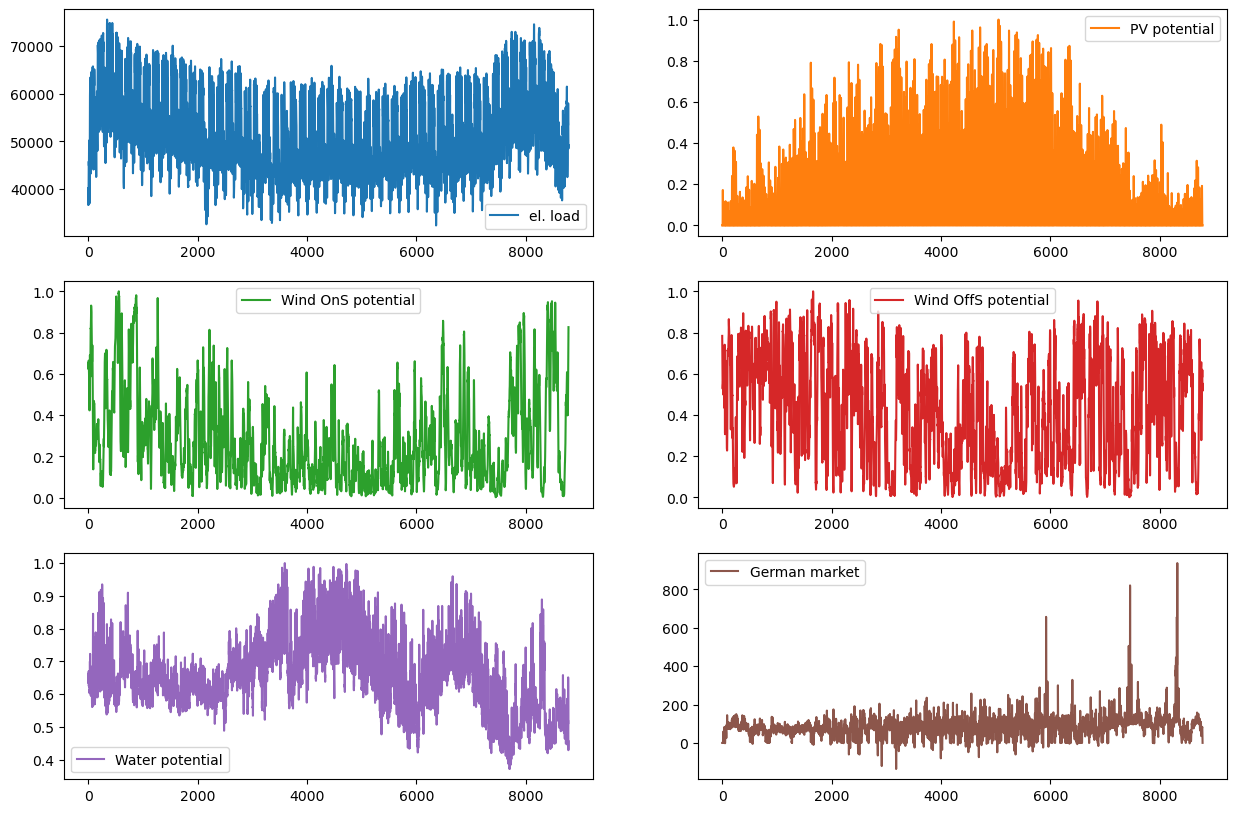

In [9]:
fig, axs = plt.subplots(figsize=(15,10),nrows=3, ncols=2)
df_data[df_data.columns[:-1]].plot(subplots=True, ax=axs)

Erstellen Sie das Netzwerk. Vernachlässigen Sie zunächst den Stromhandel mit Anreinerstaaten.

In [42]:
network = pypsa.Network()
network.set_snapshots(df_data.index)

network.add('Carrier', name = 'gas', co2_emissions = gas_co2)
network.add('Carrier', name = 'lignite', co2_emissions = lignite_co2)
network.add('Carrier', name = 'hardcoal', co2_emissions = hardcoal_co2)


network.add('Bus', name = 'electricity')

network.add('Load', name = 'el. load', bus = 'electricity', p_set = el_load)

network.add('Generator', name = 'lignite-fired power plants', bus = 'electricity', p_nom = lignite_p_nom,
            marginal_cost = lignite_marginal_cost, efficiency = lignite_eff, carrier = 'lignite')
network.add('Generator', name = 'hardcoal-fired power plants', bus = 'electricity', p_nom = hardcoal_p_nom,
            efficiency = hardcoal_eff, marginal_cost = hardcoal_marginal_cost, carrier = 'hardcoal')
network.add('Generator', name = 'gas power plants', bus = 'electricity', p_nom = gas_p_nom,
            efficiency = gas_eff, marginal_cost = gas_marginal_cost, carrier = 'gas')
network.add('Generator', name = 'biomass-fired power plant', bus = 'electricity', p_nom = biomass_p_nom,
            efficiency = biomass_eff, marginal_cost = biomass_marginal_cost)
network.add('Generator', name = 'pv', bus= 'electricity', 
            p_nom = pv_p_nom, p_max_pu = pv_p_max_pu)
network.add('Generator', name = 'wind onshore', bus= 'electricity', 
            p_nom = wind_ons_p_nom, p_max_pu = wind_ons_p_max_pu)
network.add('Generator', name = 'wind offshore', bus= 'electricity', 
            p_nom = wind_offs_p_nom, p_max_pu = wind_offs_p_max_pu)
network.add('Generator', name = 'runoff river', bus= 'electricity', 
            p_nom = water_p_nom, p_max_pu = water_p_max_pu)

network.add('StorageUnit',
            name = 'pumped storage power plant',
            bus = 'electricity',
            p_nom = pumped_storage_p_nom,
            efficiency_dispatch = pumped_storage_eff,
            max_hour = pumped_storage_e_nom/pumped_storage_p_nom,
            cyclic_state_of_charge = True)
network.add('StorageUnit',
            name = 'battery',
            bus = 'electricity',
            p_nom = pumped_storage_p_nom,
            efficiency_store = battery_eff**0.5,
            efficiency_dispatch = battery_eff**0.5,
            max_hour = battery_e_nom/battery_p_nom,
            cyclic_state_of_charge = True)






Index(['battery'], dtype='object')

Optimieren Sie das Netzwerk

In [43]:
network.optimize(solver_name='gurobi', threads = 1)

Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 17.90it/s]
INFO:linopy.io: Writing time: 1.75s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-4e80a104.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-4e80a104.lp


Reading time = 0.48 seconds


INFO:gurobipy:Reading time = 0.48 seconds


obj: 272304 rows, 122976 columns, 421632 nonzeros


INFO:gurobipy:obj: 272304 rows, 122976 columns, 421632 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 272304 rows, 122976 columns and 421632 nonzeros


INFO:gurobipy:Optimize a model with 272304 rows, 122976 columns and 421632 nonzeros


Model fingerprint: 0xd80116be


INFO:gurobipy:Model fingerprint: 0xd80116be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [7e+01, 1e+02]


INFO:gurobipy:  Objective range  [7e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-01, 8e+04]


INFO:gurobipy:  RHS range        [4e-01, 8e+04]


Presolve removed 247064 rows and 46059 columns


INFO:gurobipy:Presolve removed 247064 rows and 46059 columns


Presolve time: 0.38s


INFO:gurobipy:Presolve time: 0.38s


Presolved: 25240 rows, 76917 columns, 127233 nonzeros


INFO:gurobipy:Presolved: 25240 rows, 76917 columns, 127233 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5266026e+09   3.558727e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5266026e+09   3.558727e+07   0.000000e+00      0s


   32107    1.4313489e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   32107    1.4313489e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 32107 iterations and 1.10 seconds (0.69 work units)


INFO:gurobipy:Solved in 32107 iterations and 1.10 seconds (0.69 work units)


Optimal objective  1.431348911e+10


INFO:gurobipy:Optimal objective  1.431348911e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122976 primals, 272304 duals
Objective: 1.43e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [49]:
network.buses_t['marginal_price'].mean()

Bus
electricity    72.380044
dtype: float64

In [47]:
df_data['German market'].mean()

78.51203324225867

Wie groß war der EE-Anteil am Stromverbrauch?

In [52]:
(network.generators_t.p.sum()['runoff river'] + network.generators_t.p.sum()['pv'] + network.generators_t.p.sum()['biomass-fired power plant'] + network.generators_t.p.sum()['wind onshore'] + network.generators_t.p.sum()['wind offshore'])/network.generators_t.p.sum().sum()


0.7514187289369725

Berechnen Sie die mittleren Stromkosten über die Grenzkosten. Diese können Sie am Bus über network.buses_t.marginal_price auslesen. <br>
Wie Groß ist die Differenz zu den mittleren Stromkosten aus dem Jahr 2024?

In [53]:
print(network.buses_t.marginal_price['electricity'].mean())
print(df_data['German market'].mean())
print((network.buses_t.marginal_price['electricity'] - df_data['German market']).mean())

72.38004445800195
78.51203324225867
-6.131988784256708


Vergleichen Sie die Verläufe der optimierten und realen Stromkosten und berechnen Sie sich die mittlere quadratische Abweichung.

In [54]:
np.mean(((df_data['German market'] - network.buses_t.marginal_price['electricity']) ** 2) ** 0.5)

23.268022034975754

Lassen Sie sich die Grenzkosten an Ihrem Strombus geordent ausgeben. Wie sind die Plateaus zu erklären? Wie sieht dieser Verlauf bei den real Grenzkosten aus?

<Axes: >

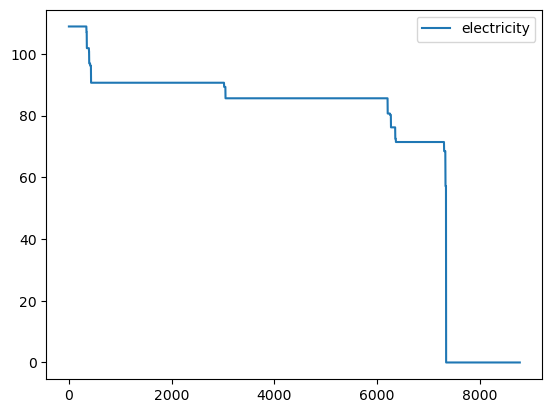

In [55]:
network.buses_t.marginal_price['electricity'].sort_values(ascending=False).reset_index().drop('snapshot',axis=1).plot()

<Axes: >

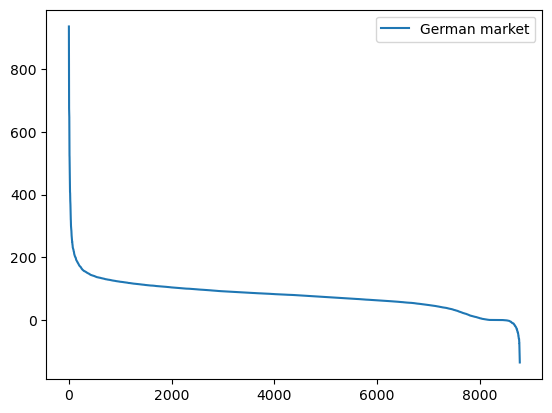

In [56]:
df_data['German market'].sort_values(ascending=False).reset_index().drop('index',axis=1).plot()

Implementieren Sie nun ebenfalls den Handel mit Anreinerstaaten. Verwenden Sie für die Import/Export-Preise die durchschnittlichen Strompreise der Anreinerstaaten. Welche Preise müsste man für den Export eigentlich verwenden?

In [57]:
network.add('Generator',
            name = 'market_import',
            bus = 'electricity',
            p_nom = np.inf,
            marginal_cost = foreign_price)
network.add('Generator',
            name = 'market_export',
            bus = 'electricity',
            p_nom = np.inf,
            marginal_cost = foreign_price * -1,
            sign = -1)

Index(['market_export'], dtype='object')

In [58]:
network.optimize(solver_name = 'gurobi')

Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 15.51it/s]
INFO:linopy.io: Writing time: 1.99s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-mk47mtjy.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-mk47mtjy.lp


Reading time = 0.54 seconds


INFO:gurobipy:Reading time = 0.54 seconds


obj: 289872 rows, 140544 columns, 456768 nonzeros


INFO:gurobipy:obj: 289872 rows, 140544 columns, 456768 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 289872 rows, 140544 columns and 456768 nonzeros


INFO:gurobipy:Optimize a model with 289872 rows, 140544 columns and 456768 nonzeros


Model fingerprint: 0xc40b0176


INFO:gurobipy:Model fingerprint: 0xc40b0176


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 1e+00]


INFO:gurobipy:  Matrix range     [9e-01, 1e+00]


  Objective range  [1e-02, 7e+02]


INFO:gurobipy:  Objective range  [1e-02, 7e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-01, 8e+04]


INFO:gurobipy:  RHS range        [4e-01, 8e+04]


Presolve removed 272306 rows and 87856 columns


INFO:gurobipy:Presolve removed 272306 rows and 87856 columns


Presolve time: 0.24s


INFO:gurobipy:Presolve time: 0.24s


Presolved: 17566 rows, 52688 columns, 70252 nonzeros


INFO:gurobipy:Presolved: 17566 rows, 52688 columns, 70252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.756e+04


INFO:gurobipy: AA' NZ     : 1.756e+04


 Factor NZ  : 2.950e+05 (roughly 30 MB of memory)


INFO:gurobipy: Factor NZ  : 2.950e+05 (roughly 30 MB of memory)


 Factor Ops : 6.216e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.216e+06 (less than 1 second per iteration)


 Threads    : 10


INFO:gurobipy: Threads    : 10


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.61727928e+10 -1.97716021e+11  1.11e+03 9.09e-13  3.73e+06     1s


INFO:gurobipy:   0   1.61727928e+10 -1.97716021e+11  1.11e+03 9.09e-13  3.73e+06     1s


   1   1.26871521e+10 -3.27542028e+10  6.82e-13 1.82e-12  4.31e+05     1s


INFO:gurobipy:   1   1.26871521e+10 -3.27542028e+10  6.82e-13 1.82e-12  4.31e+05     1s


   2   1.24959543e+10  7.74964778e+09  3.41e-13 9.09e-13  4.50e+04     2s


INFO:gurobipy:   2   1.24959543e+10  7.74964778e+09  3.41e-13 9.09e-13  4.50e+04     2s


INFO:gurobipy:


Barrier performed 2 iterations in 2.14 seconds (0.27 work units)


INFO:gurobipy:Barrier performed 2 iterations in 2.14 seconds (0.27 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   16834    1.1137259e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   16834    1.1137259e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 16834 iterations and 7.28 seconds (0.39 work units)


INFO:gurobipy:Solved in 16834 iterations and 7.28 seconds (0.39 work units)


Optimal objective  1.113725858e+10


INFO:gurobipy:Optimal objective  1.113725858e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140544 primals, 289872 duals
Objective: 1.11e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [60]:
network.buses_t.marginal_price.mean()

Bus
electricity    71.439208
dtype: float64

Vergleichen Sie die importieren und exportieren Energiemengen mit den Realdaten. <br>
Stromimport und Stromexport in Deutschland 2024: <br>
Import:&emsp;     77.2 TWh <br>
Export:&emsp;    -48.9 TWh <br>
Netto:&emsp;      28.3 TWh <br>

In [62]:
print("Import:", round(network.generators_t.p.market_import.sum()/1000000,2), "TWh")
print("Export:", round(network.generators_t.p.market_export.sum()*-1/1000000,2), "TWh")
print("Netto:", round((network.generators_t.p.market_import.sum() - network.generators_t.p.market_export.sum())/1000000,2), "TWh")
print()
print("Realimport: 77.2 TWh")
print("Realexport: -48.9 TWh")
print("Realnetto: 28.3 TWh")

Import: 94.73 TWh
Export: -75.69 TWh
Netto: 19.04 TWh

Realimport: 77.2 TWh
Realexport: -48.9 TWh
Realnetto: 28.3 TWh


<Axes: >

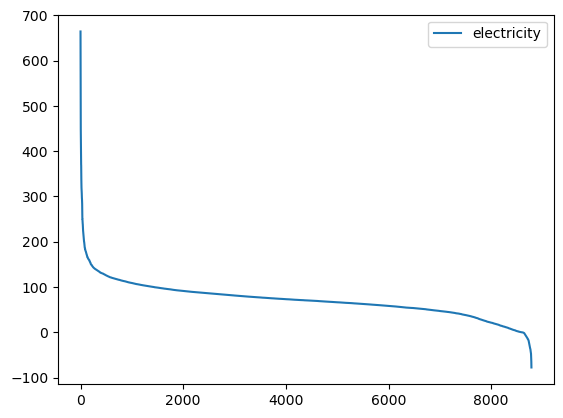

In [63]:
network.buses_t.marginal_price['electricity'].sort_values(ascending=False).reset_index().drop('snapshot',axis=1).plot()